# RAG Over PDFs with ColNomic Embed Multimodal

![banner image](https://assets.nomicatlas.com/pdf-rag-colnomic-embed-multimodal.png)

ColNomic Embed Multimodal is a late interaction embedding model that processes both text and images. It can directly process the visual content in PDFs without requiring preprocessing steps like OCR or image captioning.

In this notebook, we demonstrate how to build multimodal RAG that can answer questions from PDFs containing both text and visual elements.

**Note: due to the use of Flash Attention in this notebook, compatible GPUs such as the Ampere series (A10, A100, etc) are required. It should cost you < $1 in Colab compute credits on an A100.**

## Setup

Make sure the required libraries are installed. Note that we use the Nomic fork of `byaldi` (for compatibility with the new `colnomic-embed-multimodal` model).

In [2]:
!sudo apt-get install --quiet -y poppler-utils libvips

Reading package lists...
Building dependency tree...
Reading state information...
libvips42 is already the newest version (8.12.1-1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [9]:
!pip install -q git+https://github.com/nomic-ai/byaldi.git git+https://github.com/illuin-tech/colpali.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not

In [12]:
!pip install -q git+https://github.com/huggingface/transformers accelerate flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [16]:
!pip install -q qwen-vl-utils[decord]==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 114.3 MB/s eta 0:00:00


In [5]:
!pip install -q matplotlib pdf2image accelerate pyvips

## Preview PDF

We are going to use a pdf of data from the US Department of Labor you can download running the following command or by visiting the link [here](https://assets.nomicatlas.com/department-of-labor-data.pdf).

In [2]:
!curl -o department-of-labor-data.pdf https://assets.nomicatlas.com/department-of-labor-data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  586k  100  586k    0     0  6324k      0 --:--:-- --:--:-- --:--:-- 6376k


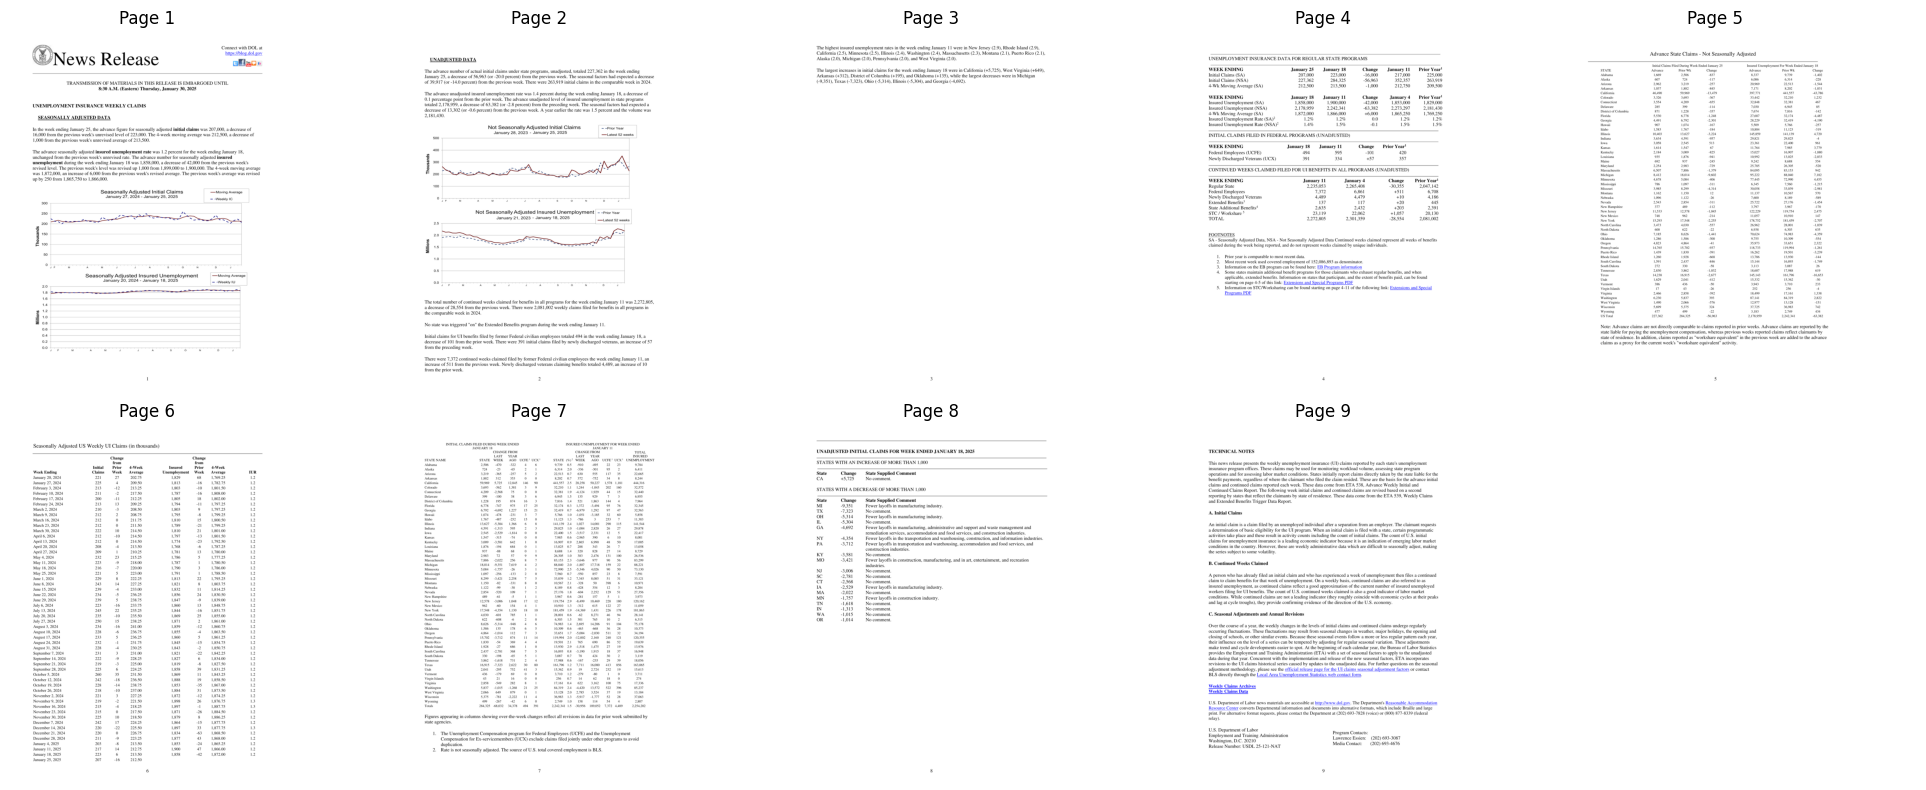

In [3]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

def display_pdf_images(images_list):
    """Display all images in the provided list as subplots with 5 images per row."""
    num_images = len(images_list)
    num_rows = num_images // 5 + (1 if num_images % 5 > 0 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    if num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    else:
        axes = axes.flatten()
    for i, img in enumerate(images_list):
        if i < len(axes):
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Page {i+1}")
            ax.axis('off')
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

pdf_images = convert_from_path("department-of-labor-data.pdf")

display_pdf_images(pdf_images)

## Create RAG Index

We create a RAG index over the PDF using the [`byaldi`](https://github.com/AnswerDotAI/byaldi) library with `colnomic-embed-multimodal` as our retriever.

**Note: This is *much* faster on GPU than CPU.**

In [4]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained(
    "nomic-ai/colnomic-embed-multimodal-3b",
    device="cuda:0"
)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of ColQwen2_5 were not initialized from the model checkpoint at Qwen/Qwen2.5-VL-3B-Instruct and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some kwargs in processor config are unused and will not have any effect: max_num_visual_tokens. 


In [5]:
RAG.index(
    input_path="department-of-labor-data.pdf",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: 'department-of-labor-data.pdf'}

## Setup Retrieval and VLM Querying

The `query_image` function uses a vision-language model (VLM) to ask a question of an image, which we will use to answer the user query.

In [6]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL.Image import Image as PILImage

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

def query_vlm(query: str, images: list[PILImage]) -> str:
    """Queries Qwen VLM with text and images"""

    system_prompt = "You are an expert professional PDF analyst who gives rigorous in-depth answers."
    message_content = [
        {"type": "image", "image": image}
        for image in images
    ] + [{"type": "text", "text": query}]
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        },
        {
            "role": "user",
            "content": message_content
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=1000)
    generated_ids_trimmed = generated_ids[0][len(inputs.input_ids[0]):]
    return processor.decode(generated_ids_trimmed, skip_special_tokens=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Plotting Helper Function

In [121]:
import textwrap
from matplotlib import gridspec
import numpy as np

def plot_rag_result(query: str, answer: str, images: list[PILImage]) -> None:
    """Plots user query, retrieved source doc as image(s), and VLM answer"""
    wrapped_query = '\n'.join(textwrap.wrap(query, width=60))
    num_images = len(images)
    fig = plt.figure(figsize=(14, 10))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    if num_images == 1:
        ax1 = fig.add_subplot(outer[0])
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title("Source Document\nretrieved by ColNomic Embed Multimodal",
                      fontsize=12, fontweight='bold', loc='left', pad=0)
    else:
        left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
        fig.text(0.01, 0.9, "Source Documents\nretrieved by ColNomic Embed Multimodal",
                fontsize=12, fontweight='bold', va='top', ha='left')
        if num_images == 2:
            rows, cols = 1, 2
        else:
            cols = min(int(np.ceil(np.sqrt(num_images))), 3)
            rows = int(np.ceil(num_images / cols))
        inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=left[0],
                                                wspace=0.05, hspace=0.05)
        for i, image in enumerate(images):
            ax_sub = fig.add_subplot(inner[i])
            ax_sub.imshow(image)
            ax_sub.axis('off')
    ax2 = fig.add_subplot(outer[1])
    ax2.axis('off')
    ax2.set_title("Answer generated by Qwen 2.5 VL Instruct", fontsize=12, fontweight='bold', loc='left')
    wrapped_answer = '\n'.join(['\n'.join(textwrap.wrap(line, width=70)) for line in answer.split('\n')])
    ax2.text(0.02, 0.97, wrapped_answer, transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2C3E50', linewidth=2, pad=1.0))
    fig.suptitle(f"Query: {wrapped_query}", fontsize=16, fontweight='bold', y=0.96)
    plt.show()

# Single Document Retrieval

In [61]:
single_doc_query = "Did any states show a decrease in unemployment claims?"
single_doc_rag_results = RAG.search(single_doc_query, k=1)
single_doc_image = pdf_images[single_doc_rag_results[0]["page_num"] - 1]
single_doc_answer = query_vlm(single_doc_query, [single_doc_image])

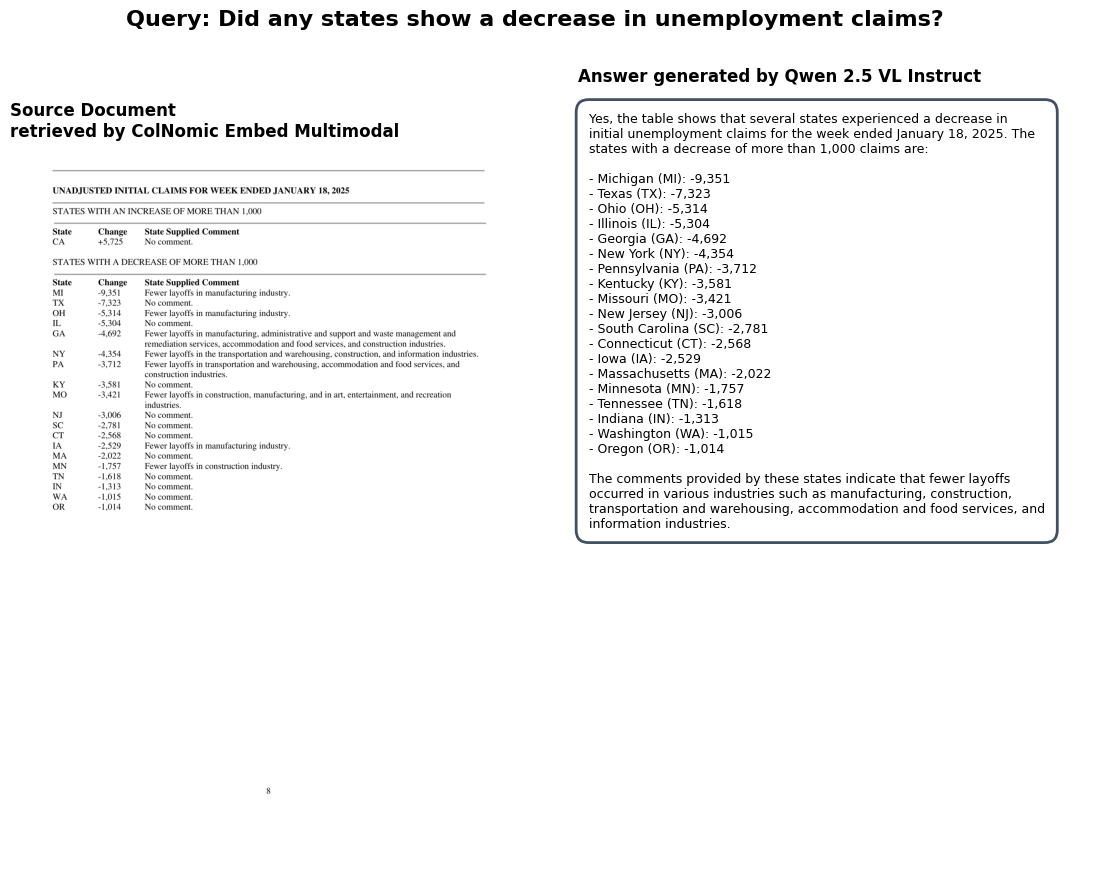

In [104]:
plot_rag_result(single_doc_query, single_doc_answer, [single_doc_image])

Now we'll display the page in more detail so you can see how the model's answers align with the retrieved source page.

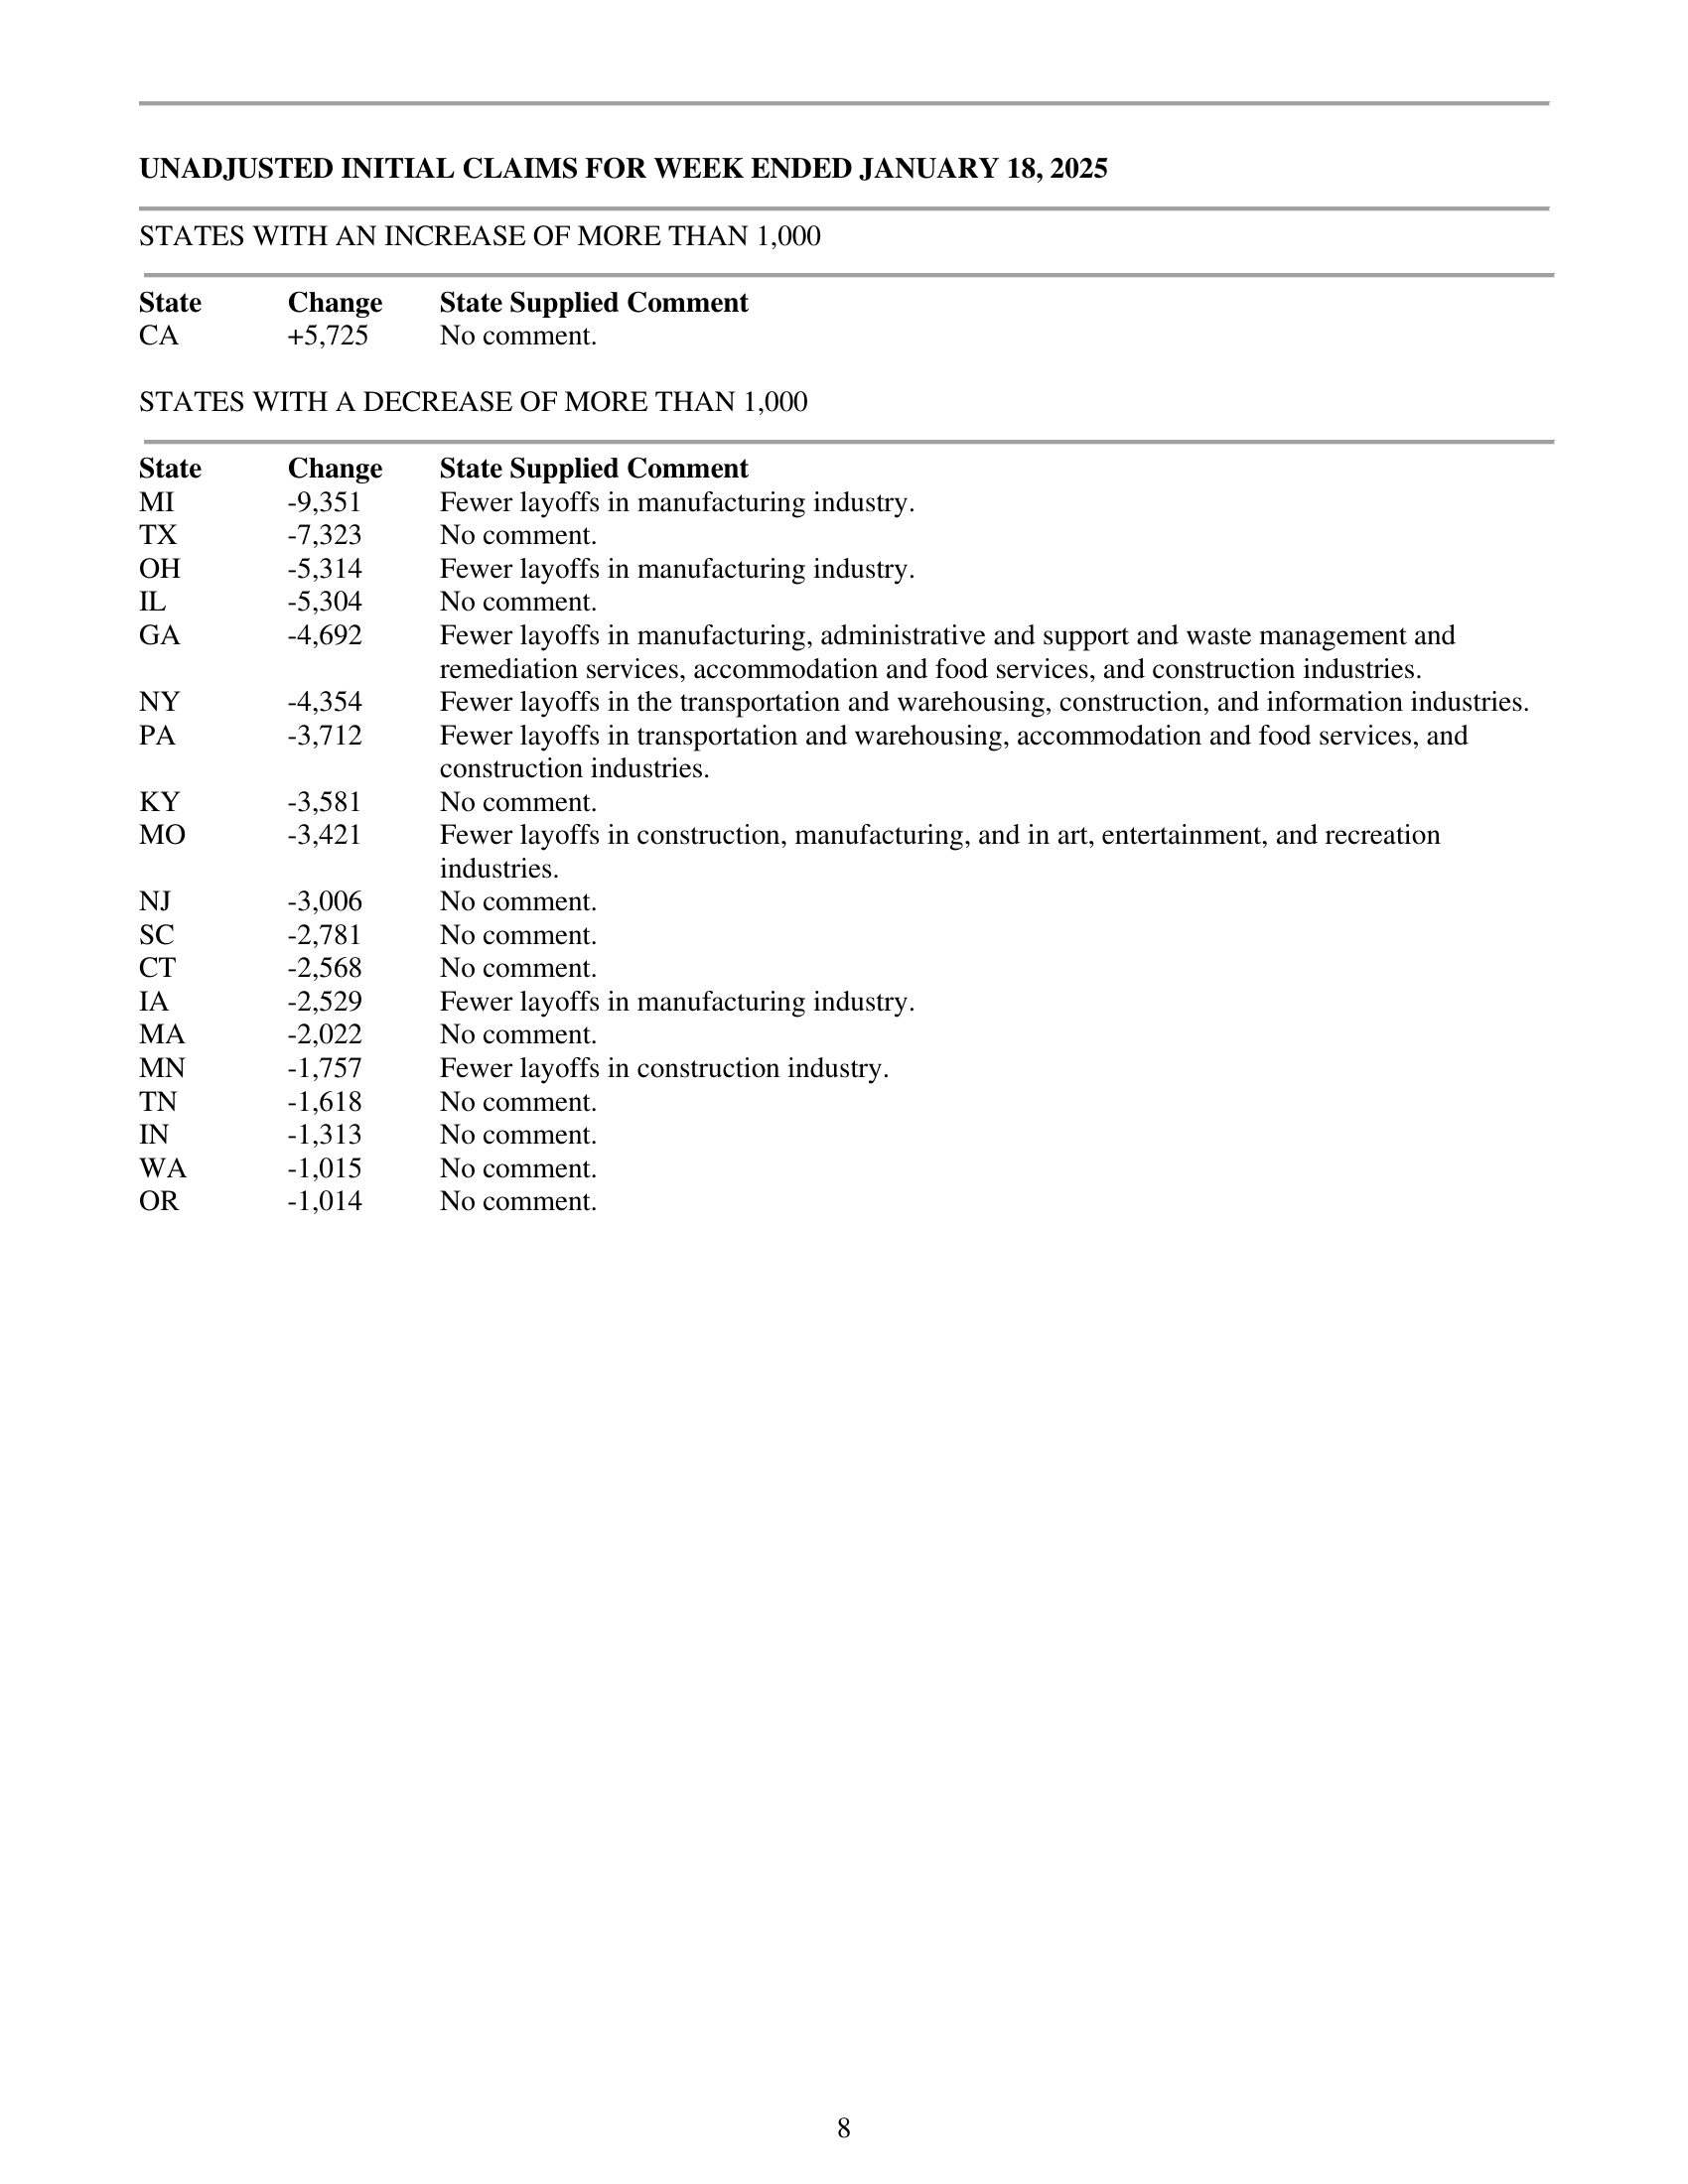

In [130]:
single_doc_image

# Multi Document Retrieval

In [125]:
multi_doc_query = "How does the data for seasonally adjusted claims differ from unadjusted claims in this report?"
K = 2
multi_doc_rag_results = RAG.search(multi_doc_query, k=K)
multi_doc_images = [pdf_images[multi_doc_rag_results[i]["page_num"] - 1] for i in range(K)]
multi_doc_answer = query_vlm(multi_doc_query, multi_doc_images)

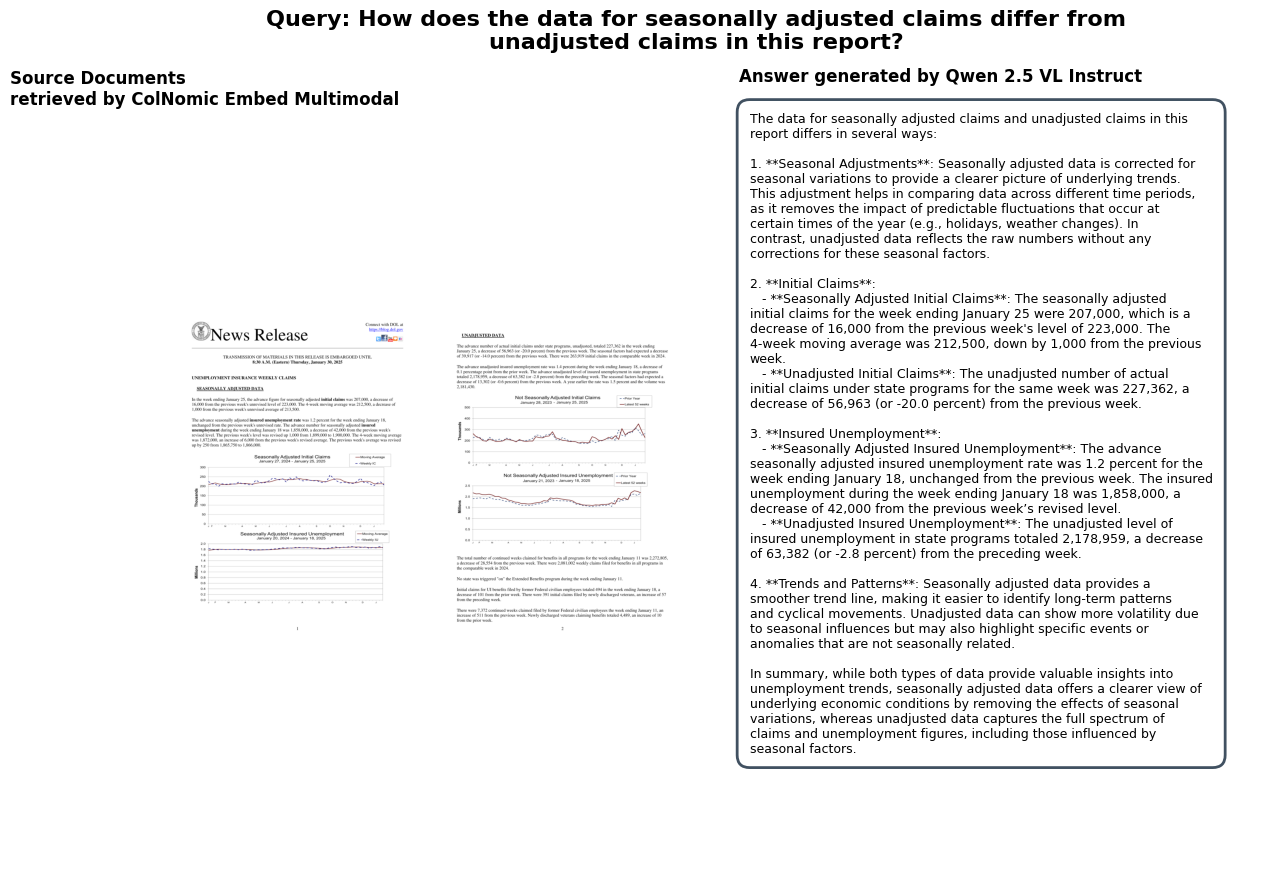

In [126]:
plot_rag_result(multi_doc_query, multi_doc_answer, multi_doc_images)

Now we'll display the pages in more detail so you can see how the model's answers align with the retrieved source pages.

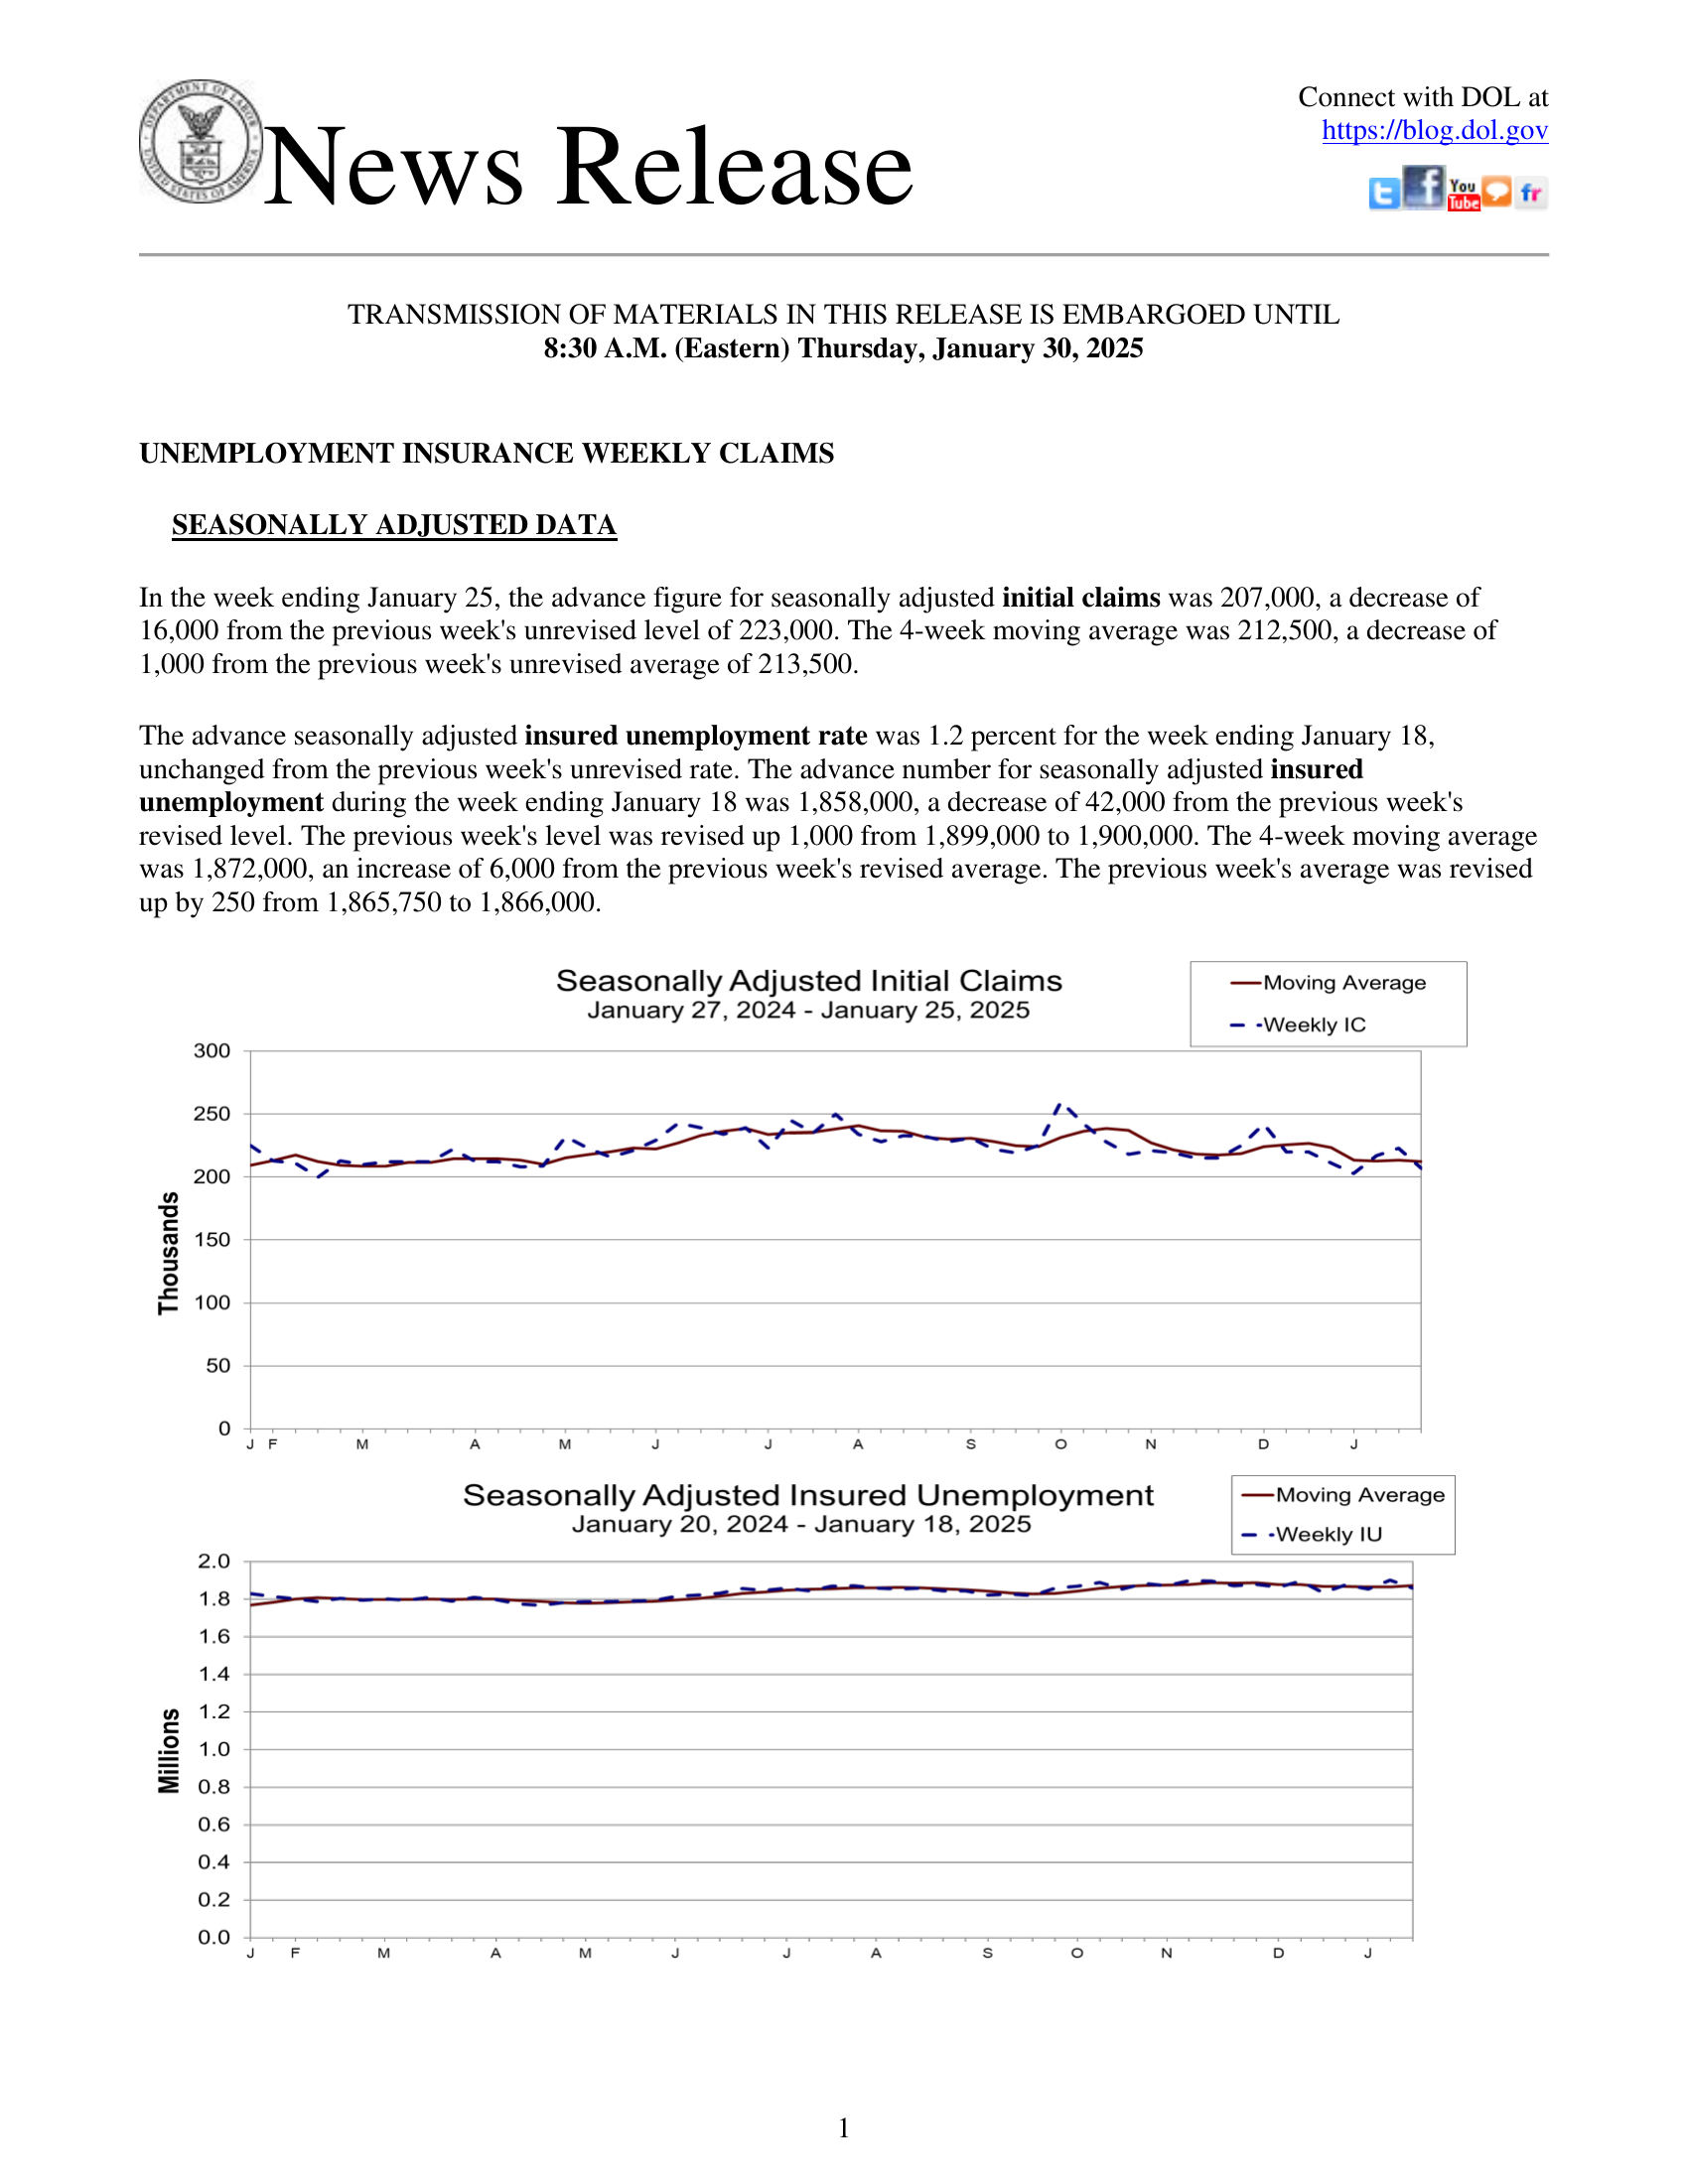

In [128]:
multi_doc_images[0]

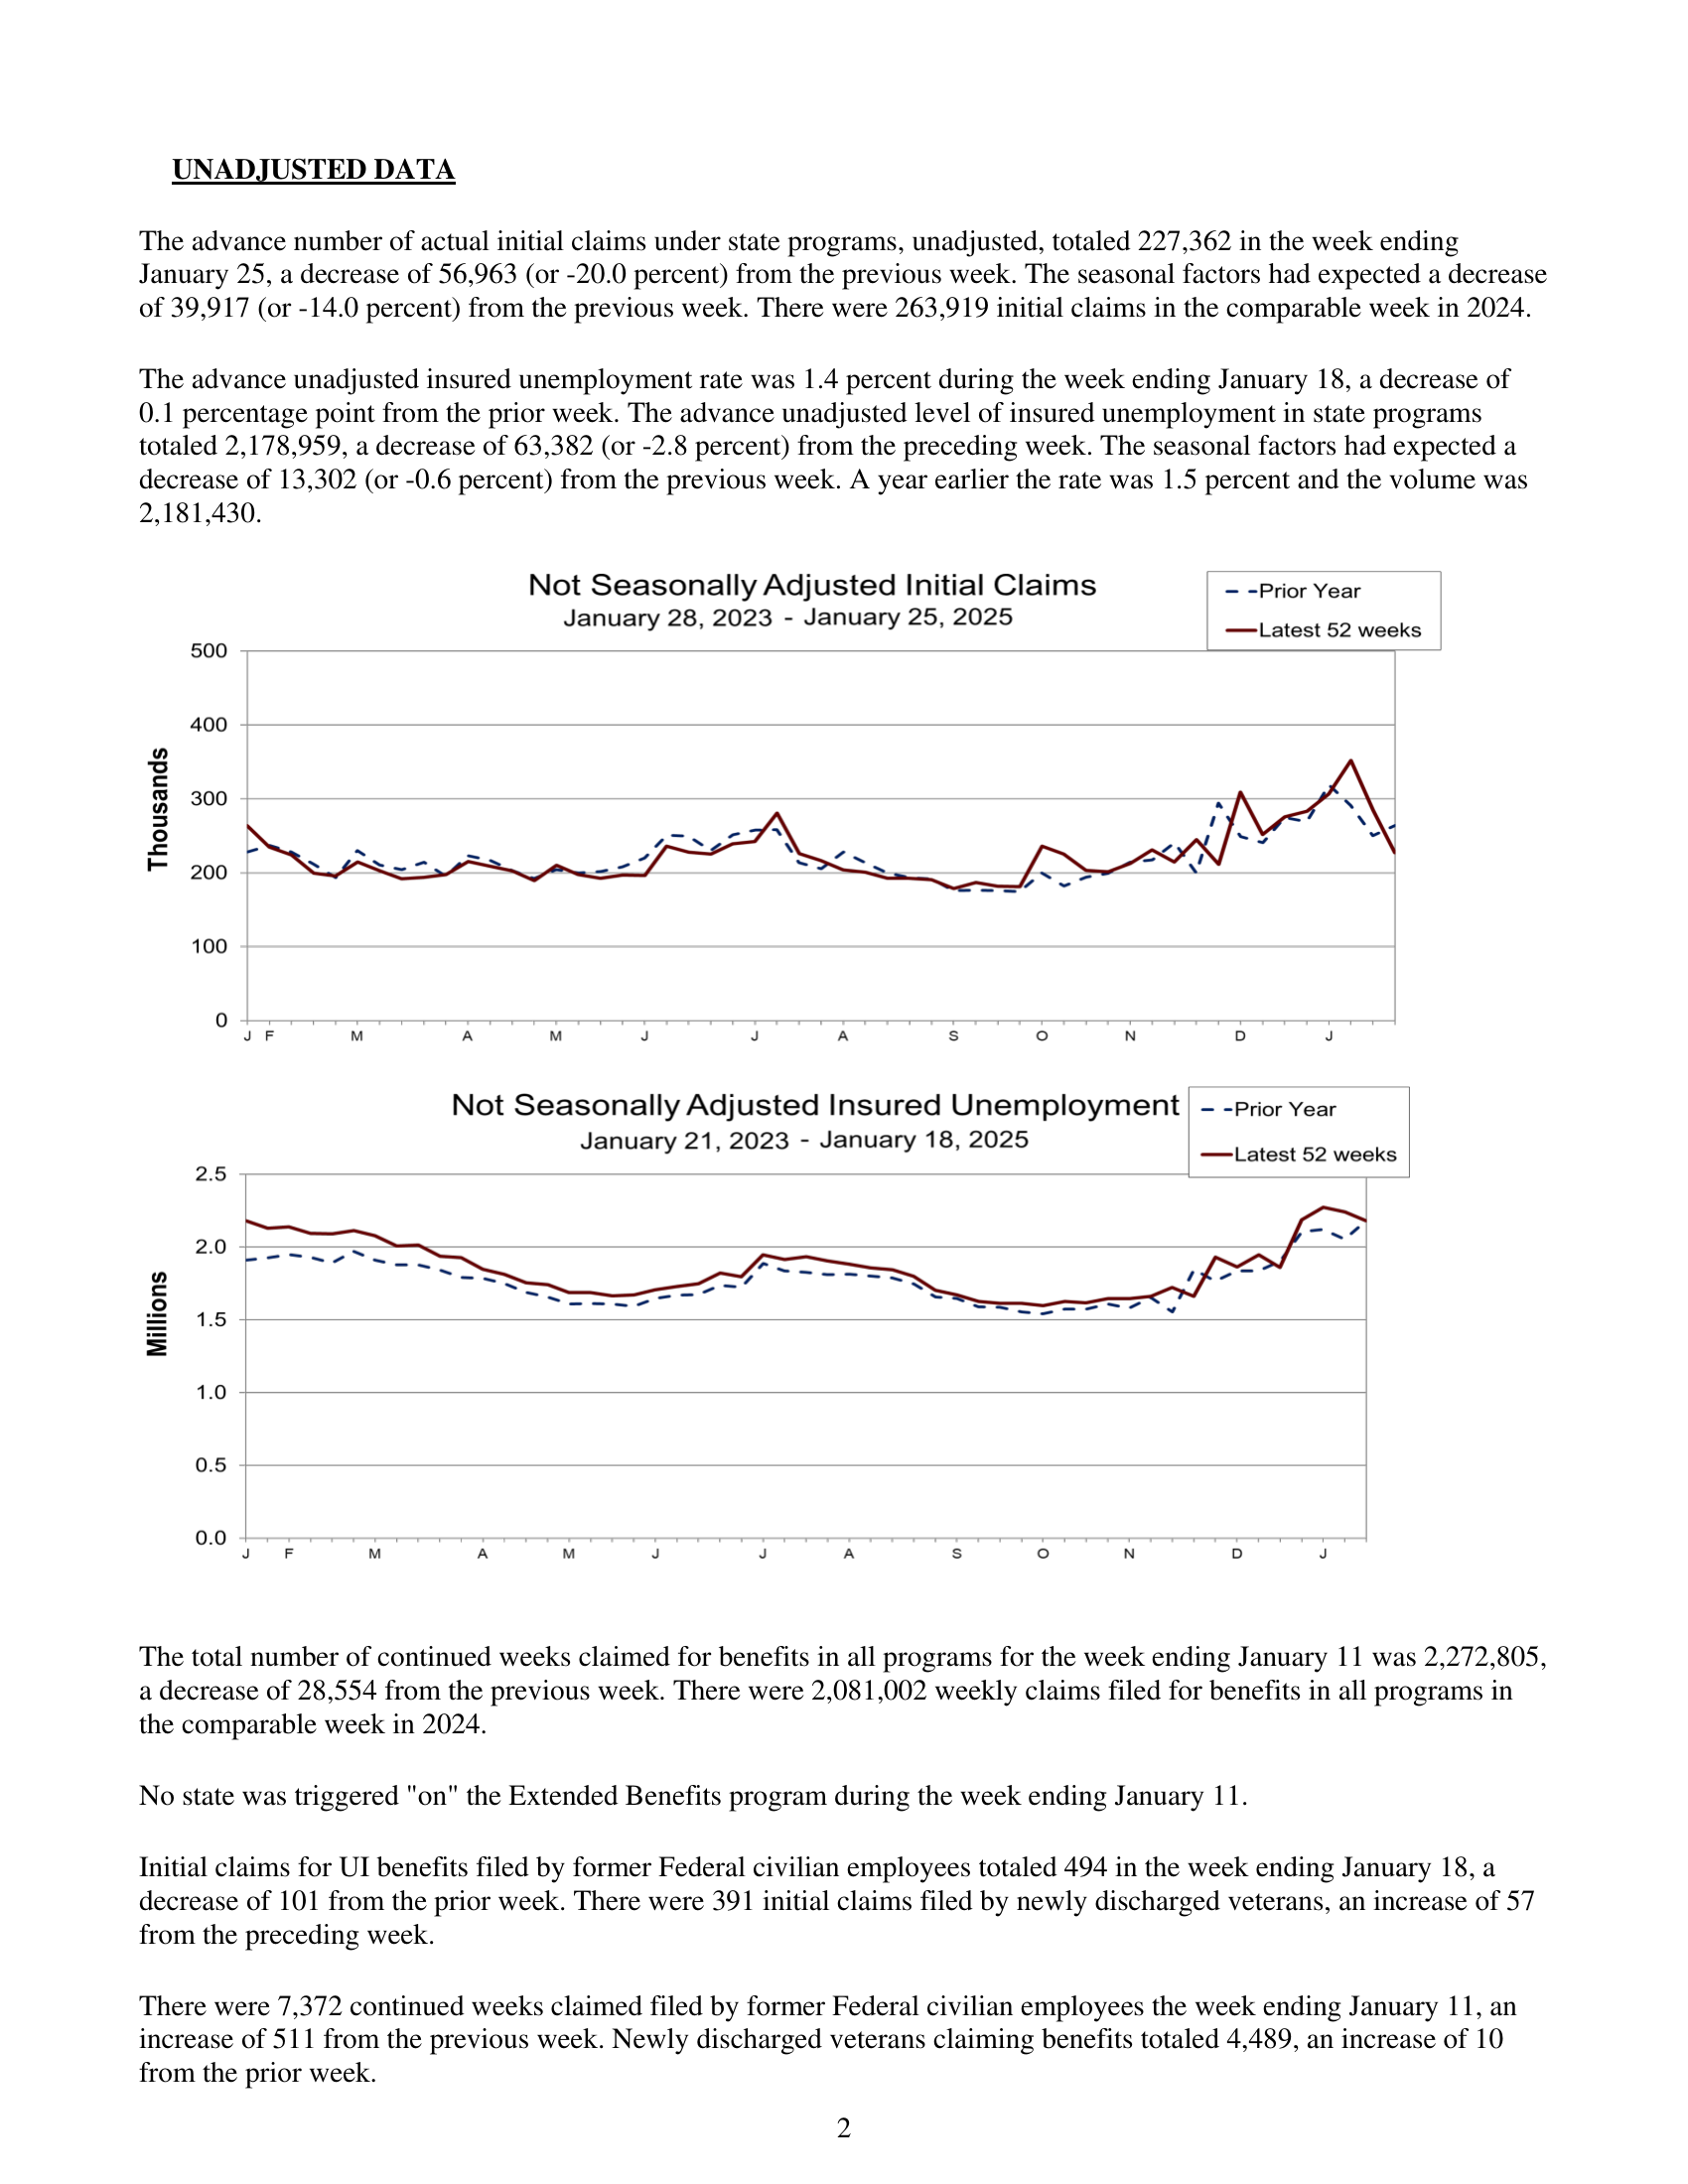

In [129]:
multi_doc_images[1]